[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neurogym/ngym_usage/blob/master/supervised/auto_notebooks/supervised/PerceptualDecisionMaking-v0.ipynb)

# Recurrent Neural Networks

## 0. Installs, packages, auxiliary functions

### 0.1. Install Neurogym

We will use the toolbox [**Neurogym**](https://github.com/neurogym/neurogym/) to define the tasks that our RNNs will have to learn. 
**NeuroGym** is a curated collection of neuroscience tasks with a common interface. It's main goal is to facilitate training of neural network models on neuroscience tasks.

<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1Suk5bvKiFqZCmIu4f1pWNghBxrznJ0U_" alt="drawing" width="1000"/>
</p>

In [1]:
# Uncomment following lines to install
# ! pip install gym   # Install gym
# ! git clone https://github.com/gyyang/neurogym.git  # Install neurogym
# %cd neurogym/
# ! pip install -e .

### 0.2. Imports

Import the packages we need for training and analyzing the RNNs. Especially, we will use the toolbox [pytorch](https://pytorch.org/) to define and train the networks.

In [2]:
# packages to save data
import os
from pathlib import Path
import json

# packages to handle data
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

# packages to visualize data
import matplotlib.pyplot as plt

# import torch and neural network modules to build RNNs
import torch
import torch.nn as nn

# import gym and neurogym to create tasks
import gym
import neurogym as ngym
from neurogym.utils import plotting

# check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# name of the task on the neurogym library
envid = 'PerceptualDecisionMaking-v0'
# other tasks to try: 'DelayMatchSample-v0', 'GoNogo-v0', 'ContextDecisionMaking-v0'

### 0.3. Auxiliary functions

We need to create a path to save the data from the network that we will analize.

In [3]:
def get_modelpath(envid):
    
    # Make a local file directories
    path = Path('.') / 'files'
    os.makedirs(path, exist_ok=True)
    path = path / envid
    os.makedirs(path, exist_ok=True)
    
    return path

## 1. Training an RNN

In this tutorial, we will work with Recurrent Neural Network (RNN) which are articificial neural networks that contain recurrent connections between their units. 

### 1.1. Training parameters

In order to train the network, we need to define some training parameters:
- *dt*: time step of the task. The task is defined in discrete time steps of 100 ms.
- *lr*: learning rate of the network.
- *n_epochs*: number of epochs to train the network.
- *seq_len*: number of time steps in each trial. The network will be trained on sequences of 100 time steps.
- *batch_size*: number of trials per batch. During training, the network will be trained on batches of trials that contain the inputs to the network and the target outputs (or labels).

In [4]:
# Set up config:
training_kwargs = {'dt': 100,
                   'lr': 1e-2,
                   'n_epochs': 2000,
                   'batch_size': 16,
                   'seq_len': 100,
                   'envid': envid}

### 1.2. Define task

We now define the task parameters:
- *dt*: already defined above.
- *timing*: timing of the different periods of the task: fixation, stimulus, delay, decision.
- *sigma*: standard deviation of the Gaussian noise that will be added to the stimulus.
- *dim_ring*: number of stimuli. Our task will have 2 stimuli and two corresponding choices, i.e. it will be a two-alternative forced choice (2AFC) task, but the task can be generalized to any number of stimuli and choices.

In [6]:
# Set up task parameters
if envid == 'PerceptualDecisionMaking-v0':
    env_kwargs = {'dt': training_kwargs['dt'],
                'timing': {'fixation': 200, 
                            'stimulus': 2000, 
                            'delay': 0, 
                            'decision': 200}, 
                'sigma': 2,                
                'dim_ring': 2}               
else:
    env_kwargs = {'dt': training_kwargs['dt']}

### 1.3. Sample dataset

After having defined how the task (*the environment*) is implemented and which are the training hyperparameters, we now define a function that builds the environment. This function also provides a dataset object, from which we will sample the trials and labels that will be used to train the network.

In [7]:
def get_dataset(envid, env_kwargs, training_kwargs):
    """
    Create neurogym dataset and environment. 

    args:
        envid (str): name of the task on the neurogym library
        env_kwargs (dict): task parameters
        training_kwargs (dict): training parameters
    
    returns:
        dataset (neurogym.Dataset): dataset object from which we can sample trials and labels
        env (gym.Env): task environment
    """

    # Make supervised dataset using neurogym's Dataset class
    dataset = ngym.Dataset(envid, 
                           env_kwargs=env_kwargs, 
                           batch_size=training_kwargs['batch_size'],
                           seq_len=training_kwargs['seq_len'])
    env = dataset.env
    
    return dataset, env

In [8]:
# call function to sample
dataset, env = get_dataset(envid=envid, env_kwargs=env_kwargs, training_kwargs=training_kwargs)

/Users/heike/anaconda3/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(


/Users/heike/anaconda3/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


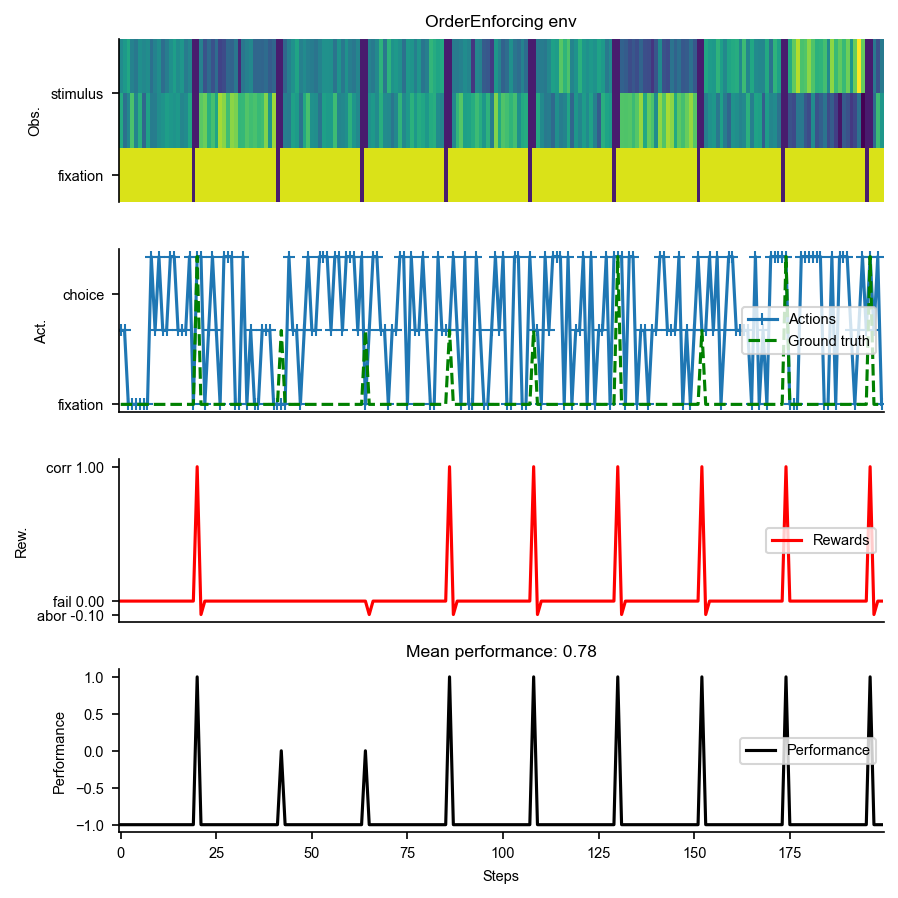

In [9]:
# Plot several trials of the task with a random agent
f = plotting.plot_env(envid, fig_kwargs={'figsize': (6, 6), 'dpi':150})

As you can see the observations (inputs) have size 3: two stimuli for the left/right choices and one fixation cue that indicates when the network should choose.

In the second panel, the target output (ground-truth) is indicated by the dashed green line and the actions in blue come from a random agent. The bottom panels indicate the reward that the random agent will recieve at each time step.

### 1.4. Define network

We will now define the network that we want to train. Recurrent neural networks are defined by a set of units that are connected to each other. 



<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1ENHA_qKp3Cl_D0qagUMAJTLHKdJpA1nb" alt="drawing" width="1000"/>
</p>


RNNs can receive an input (x) that evolves across time and produce an associated output (y) at each time step. The activity of their units at any timestep ($h_t$) is passed to the network as an extra input in the next timestep ($h_{t+1}$).  This makes them useful to process data like text or speech, although nowadays they're not so popular anymore.

Let's first define the parameters of the network:
- the number (*dimensionality*) of inputs.
- the number of hidden units (neurons) in the network.
- the dimensionality of outputs.

The connections between the different units will be defined by a matrix of weights ($W_R$) that is initialized with random values.

Then, we need to define the transfer function of the units ($g_h$) in the figure shown at the beginning of the section). We will use rectified linear units which just take the positive part of the input.

Finally, we will readout the units activity with a linear projection to the output units ($g_y$).

We will build our RNN using the pytorch library and train it on the 2AFC task that we have defined above.


In [10]:
# Set up config:
num_neurons = 64

net_kwargs = {'hidden_size': num_neurons,
              'action_size': env.action_space.n,
              'input_size': env.observation_space.shape[0]} # size of the input to the network

In the following, we define a `Net` class, which creates our network from standard modules in `pytorch`. As you know from previous tutorials, classes can have associated methods, which are functions specified uniquely for object of the respective class. Our Net class will have:
- An `_init_` method that will be run when a new object is created and defines the network architecture.
- A `forward` method, that receives the input and returns the output of the network (taking into account the network's architecture).

In [11]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        
        # INSTRUCTION 1: build a recurrent neural network with a single recurrent layer and rectified linear units
        self.vanilla = nn.RNN(input_size, hidden_size, nonlinearity='relu')
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # INSTRUCTION 2: get the output of the network for a given input
        out, _ = self.vanilla(x)
        x = self.linear(out)
        return x, out

We will now create an *instance* of the `Net` class with the desired hyperparameters as defined above. We will then pass this network to our GPU for training.

In [12]:
# Define network instance from the Net class
net = Net(input_size=env.observation_space.shape[0],
          hidden_size=net_kwargs['hidden_size'],
          output_size=env.action_space.n)

# Move network to the device (CPU or GPU)
net = net.to(device)

### 1.5. How do we train the network?



To teach the network to perform the task, we will use a supervised learning approach. This means that we will provide the network with the inputs and the target outputs (or labels) and we will train the network to predict the target outputs from the inputs. For that we need a loss function that quantifies the difference between the network's predictions and the target outputs. Here's a screenshot of this morning presentation for you to remember how we train a network using gradient descent on a loss function. 

<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1cJjCcgc3jgdrsd2nq0AsDq628nK0eUZA" alt="drawing" width="1000"/>
</p>

We will use the cross-entropy loss function, which is commonly used for classification tasks (here the network has to classify the stimuli into two categories). The cross-entropy loss function is defined as:

$$L = - \sum_{i=1}^{N} y_i \log(\hat{y}_i)$$

where L is the loss, $N$ is the number of samples, $y_i$ is the target output and $\hat{y}_i$ is the network's prediction for the $i$-th sample.

We will also define the optimizer that will be used to train the network. We will use the Adam optimizer, which is a popular optimizer that is based on the gradient descent algorithm.

In [13]:
# Define loss: instance of the CrossEntropyLoss class
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=training_kwargs['lr'])

### 1.6. Save config

In [14]:
training_kwargs['env_kwargs'] = env_kwargs
training_kwargs['net_kwargs'] = net_kwargs

# Save config
with open(get_modelpath(envid) / 'config.json', 'w') as f:
    json.dump(training_kwargs, f)

### 1.7. Supervised training of network

In [15]:
print('Training task ', envid)

num_epochs = training_kwargs['n_epochs']

# We'll keep track of the loss as we train. 
# It is initialized to zero and then monitored over training interations
running_loss = 0.0 

for i in range(num_epochs):
    
    # get inputs and labels and pass them to the GPU
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)
    labels = torch.from_numpy(labels.flatten()).type(torch.long).to(device)
    # print shapes of inputs and labels
    if i == 0:
        print('inputs shape: ', inputs.shape)
        print('labels shape: ', labels.shape)
        print('Max labels: ', labels.max())
    # we need zero the parameter gradients to re-initialize and avoid they accumulate across epochs
    optimizer.zero_grad()

    # INSTRUCTION 3: FORWARD PASS: get the output of the network for a given input
    outputs, _ = net(inputs)

    #reshape outputs so they have the same shape as labels
    outputs = outputs.view(-1, env.action_space.n)

    #  INSTRUCTION 4: compute loss with respect to the labels
    loss = criterion(outputs, labels)
    
    # INSTRUCTION 5: compute gradients
    loss.backward()
    
    # INSTRUCTION 6: update weights
    optimizer.step()

    # print average loss over last 200 training iterations and save the current network
    running_loss += loss.item()
    if i % 200 == 199:
        print('{:d} loss: {:0.5f}'.format(i + 1, running_loss / 200))
        running_loss = 0.0
        
        # save current state of network's parameters
        torch.save(net.state_dict(), get_modelpath(envid) / 'net.pth')

print('Finished Training')

Training task  PerceptualDecisionMaking-v0
inputs shape:  torch.Size([100, 16, 3])
labels shape:  torch.Size([1600])
Max labels:  tensor(2)
200 loss: 0.21833
400 loss: 0.05845
600 loss: 0.05815
800 loss: 0.05522
1000 loss: 0.04606
1200 loss: 0.03123
1400 loss: 0.02935
1600 loss: 0.02694
1800 loss: 0.02721
2000 loss: 0.02682
Finished Training


## 2. Analyze the trained RNN

### 2.1. Run network after training for analysis

We will now analyze the network that we have trained. For that we need to run the network on the task again, but this time we will record the activity of the network and the task variables. We will then save this data for later analysis.

In [16]:
# load configuration file - we might have run the training on the cloud and might now open the results locally
with open(get_modelpath(envid) / 'config.json') as f:
    config = json.load(f)

First, we will reconstruct the environment from our config file.

In [17]:
# Environment
env = gym.make(envid, **config['env_kwargs'])
try:
    env.timing = config['env_kwargs']['timing']
except KeyError:
    timing = {}
    for period in env.timing.keys():
        period_times = [env.sample_time(period) for _ in range(100)]
        timing[period] = np.median(period_times)
    env.timing = timing
env.reset(no_step=True) # this is to initialize the environment 

/Users/heike/anaconda3/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(


array([ 0.7817153, -0.4354231,  1.4999288], dtype=float32)

Now, we'll make a new instance of the `Net` class and populate it with hyperparameters from our config file, as well as the trained weights.

In [18]:
# Since we will not train the network anymore, we can turn off the gradient computation. The most commun way to do this is to use the context manager torch.no_grad() as follows:
with torch.no_grad():
    net = Net(input_size=config['net_kwargs']['input_size'],
              hidden_size=config['net_kwargs']['hidden_size'],
              output_size=config['net_kwargs']['action_size'])
    
    net = net.to(device) # pass to GPU for running forwards steps
    
    # load the trained network's weights from the saved file
    net.load_state_dict(torch.load(get_modelpath(envid) / 'net.pth'))

    # how many trials to run
    num_trial = 1000
    
    # empty lists / dataframe to store activity, choices, and trial information
    activity = list()
    obs = list()
    info = pd.DataFrame()
    
    for i in range(num_trial):

        # create new trial
        env.new_trial()
        
        # read out the inputs in that trial
        inputs = torch.from_numpy(env.ob[:, np.newaxis, :]).type(torch.float)
        # as before you can print the shapes of the variables to understand what they are and how to use them
        # do this for the rest of the variables as you build the code
        if i == 0:
            print('Shape of inputs: ' + str(inputs.shape))
        # INSTRUCTION 7: get the network's prediction for the current input
        action_pred, hidden = net(inputs)
        action_pred = action_pred.numpy()
        
        # INSTRUCTION 8: get the network's choice
        choice = np.argmax(action_pred[-1, 0, :])
        
        # INSTRUCTION 9: check if the choice is correct
        correct = choice == env.gt[-1]

        # Log trial info
        trial_info = env.trial
        trial_info.update({'correct': correct, 'choice': choice}) # write choices and outcome
        info = info.append(trial_info, ignore_index=True)
        
        # Log activity
        activity.append(np.array(hidden)[:, 0, :])
        
        # Log the inputs (or observations) received by the network
        obs.append(env.ob)

    print('Average performance', np.mean(info['correct']))

activity = np.array(activity)
obs = np.array(obs)

# print stats of the activity: max, min, mean, std
print('Activity stats:')
print('Max: ' + str(np.max(activity)) + \
      ', Min: ' + str(np.min(activity)) + \
      ', Mean: ' + str(np.mean(activity)) + \
      ', Std: ' + str(np.std(activity)) + \
        ', Shape: ' + str(activity.shape))

Shape of inputs: torch.Size([24, 1, 3])
Average performance 0.838
Activity stats:
Max: 12.25514, Min: 0.0, Mean: 0.20295829, Std: 0.67227304, Shape: (1000, 24, 64)


### 2.2. General analysis

We will now inspect the network actity and observations. `activity` is of shape (100, 24, 64) (`[ntrials x ntime x nneurons]`), and observations of shape (100, 24, 3) (`[ntrials x ntime x nobs]`). 

##### Plot example trial

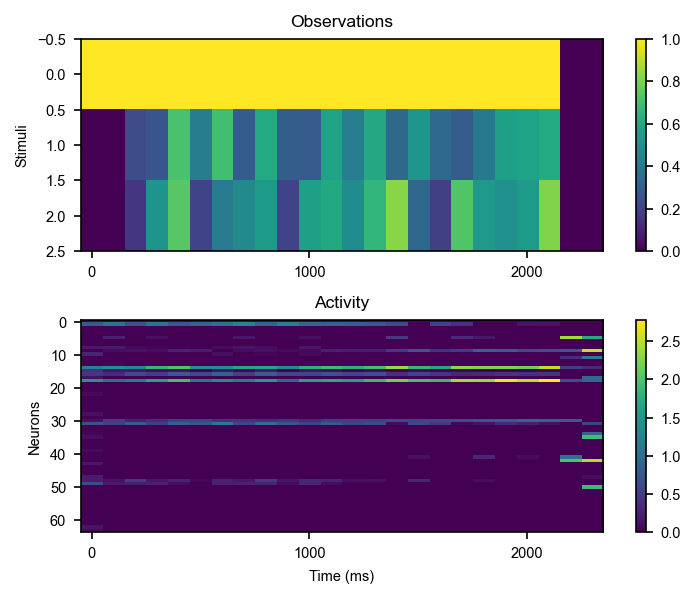

In [19]:
def plot_activity(activity, obs, config, trial):

    # Load and preprocess results
    f, ax = plt.subplots(figsize=(5, 4), nrows=2, dpi=150)

    # time in ms
    t_plot = np.arange(activity.shape[1]) * config['dt']

    # INSTRUCTION 10: plot the observations for one trial
    im = ax[0].imshow(obs[trial].T, aspect='auto', vmin=0, vmax=1)
    ax[0].set_title('Observations')
    ax[0].set_ylabel('Stimuli')

    # change the xticks to show time in ms
    ax[0].set_xticks(np.arange(0, activity.shape[1], 10))
    ax[0].set_xticklabels(t_plot[::10])
    plt.colorbar(im, ax=ax[0])
    # INSTRUCTION 11: plot the activity for one trial
    im = ax[1].imshow(activity[trial].T, aspect='auto', cmap='viridis')
    ax[1].set_title('Activity')
    ax[1].set_xlabel('Time (ms)')
    ax[1].set_ylabel('Neurons')
    plt.colorbar(im, ax=ax[1])
    # change the xticks to show time in ms
    ax[1].set_xticks(np.arange(0, activity.shape[1], 10))
    ax[1].set_xticklabels(t_plot[::10])

    plt.tight_layout()

plot_activity(activity=activity, obs=obs, config=config, trial=0)

You can see that many neurons are completely silent. Is this always like this? We will now first identify and exclude the silent neurons.

fraction of silent neurons: 0.484375


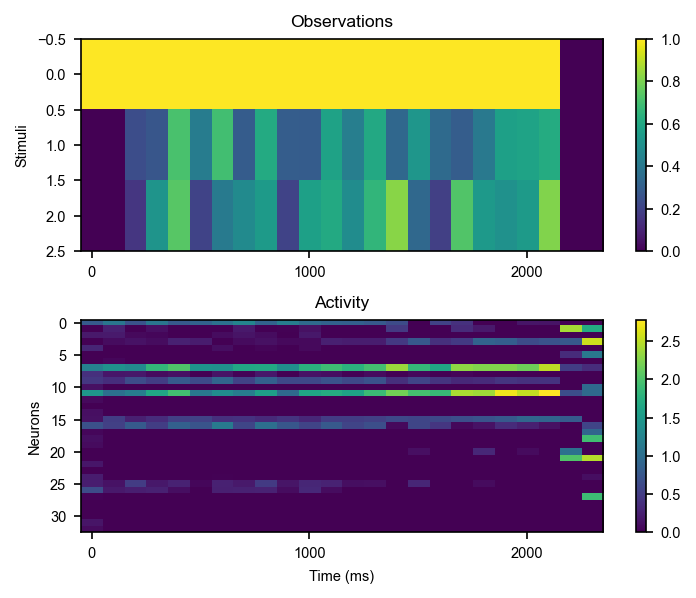

In [20]:
silent_idx = np.where(activity.sum(axis=(0, 1))==0)[0]

print('fraction of silent neurons:', len(silent_idx)/activity.shape[-1])
# remove silent neurons
clean_activity = activity[:,:,np.delete(np.arange(activity.shape[-1]), silent_idx)]
plot_activity(activity=clean_activity, obs=obs, config=config, trial=0)

 You see that 50% of the neurons are silent. Why do you think this happens?
 
 Also, as in biological networks, the active units of the RNN have different levels of activity. We will thus normalize the acitvity across all trials (so that all neurons have the same minimum and maximum activity) and plot again.

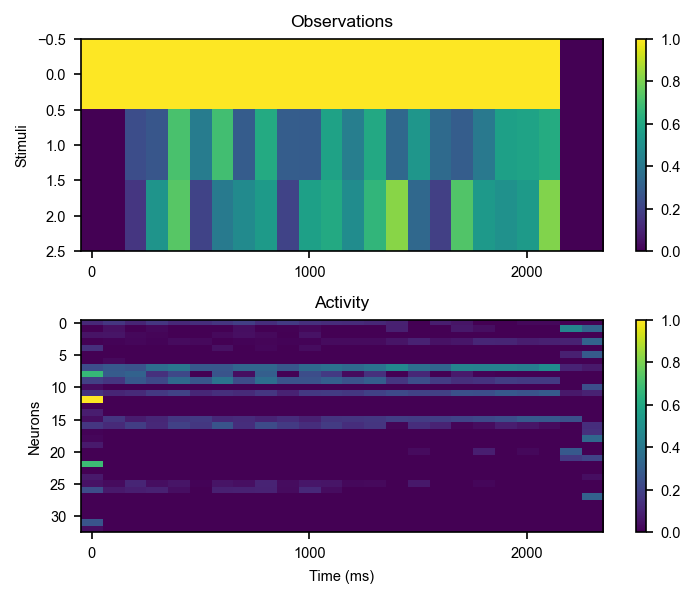

In [21]:
# min_max scaling
minmax_activity = np.array([neuron-neuron.min() for neuron in clean_activity.transpose(2,0,1)]).transpose(1,2,0)
minmax_activity = np.array([neuron/neuron.max() for neuron in minmax_activity.transpose(2,0,1)]).transpose(1,2,0)

plot_activity(activity=minmax_activity, obs=obs, config=config, trial=0)

We can see that neurons have mixed activtity profiles, corresponding to the different task periods. Can you figure out the role played by some of these neurons?

#### Plot Peristimulus histograms for the different conditions (ground-truth, reward, choice)

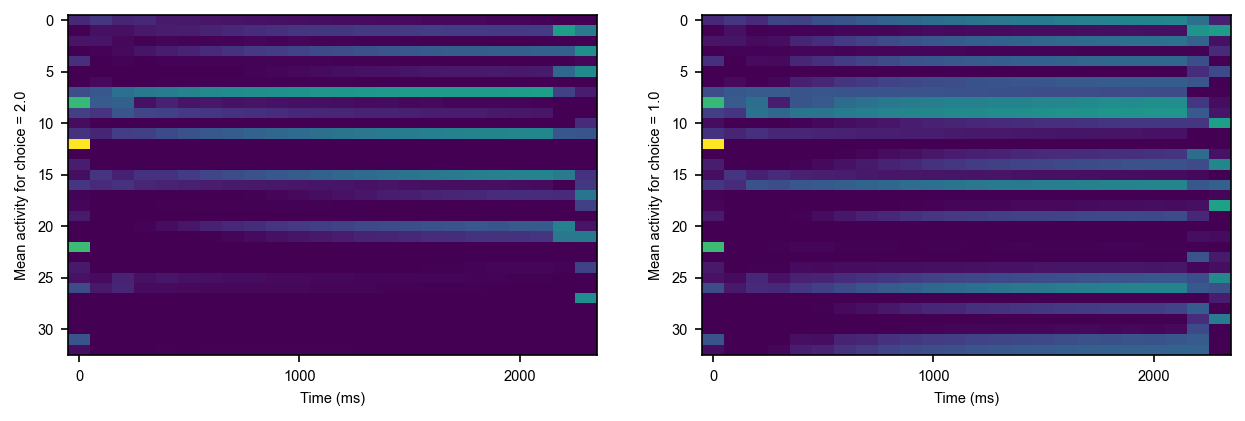

In [22]:
def analysis_activity_by_condition(activity, info, config, conditions=['choice']):
    """
    Plot single neuron activity by condition.
    """   
    for condition in conditions:
        values = pd.unique(info[condition])
        f, ax = plt.subplots(figsize=(10, 3), ncols=len(values), sharex=True, dpi=150)
        t_plot = np.arange(activity.shape[1]) * config['dt']
        for i_v, value in enumerate(values):
            # INSTRUCTION 13: plot the average activity across neurons and trials for each condition
            a = activity[info[condition] == value]
            ax[i_v].imshow(a.mean(axis=0).T, aspect='auto', cmap='viridis')
            ax[i_v].set_xlabel('Time (ms)')
            ax[i_v].set_ylabel('Mean activity for ' + condition + ' = ' + str(value))
            # change the xticks to show time in ms
            ax[1].set_xticks(np.arange(0, activity.shape[1], 10))
            ax[1].set_xticklabels(t_plot[::10])

        # plt.legend(title=condition, loc='center left', bbox_to_anchor=(1.0, 0.5))

analysis_activity_by_condition(minmax_activity, info, config, conditions=['choice']) # other conditions: correct, ground_truth

### 2.3. Behavioral analysis

Will the network behave similarly to a human participant? We have seen above that its average fraction of correct is at ~ 0.8-0.9. Let's now calculate the psychometric curve, i.e., performance by evidence levels. Use the `info` dataframe as if it was behavioral data from a participant.

### 2.4. Stimulus and choice decoding from hidden unit activity

We will now look at the information content in the hidden layers: How long does it take (after stimulus presentation) until the RNN represents stimuli reliably? We are going to use linear discriminant analysis (`sklda.LinearDiscriminantAnalysis`), which is a simple linear classifier. 

For each time bin, we will divide the `ntrials x nneurons` activity matrix, as well as the `ntrials` vector of labels (`info.ground_truth.values`) into a train and test set by calling `sklms.train_test_split()`. We will then fit LDA weights on the train set, and predict labels (left vs. right) from the test set activity to calculate the classification accuracy. 

Repeat that procedure for 100 train-test-splits to calculate the mean classification accuracy for each timepoint, as well as 95% confidence intervals over train-test-splits.

In [23]:
import sklearn.model_selection as sklms
import sklearn.discriminant_analysis as sklda

In [24]:
# number of CV splits
n_splits = 100

# set
mean_acc = np.zeros([n_splits, minmax_activity.shape[1]]) * np.nan

for i in range(n_splits):    
    
    # transpose tensor to be shape [trials, time, neurons]
    for xi,x in enumerate(minmax_activity.transpose(1,0,2)):

        # train-test-split
        x_train, x_test, y_train, y_test = sklms.train_test_split(x, info.ground_truth.values, random_state=i)

        # fit to train data
        lda_fitted = sklda.LinearDiscriminantAnalysis(solver='lsqr').fit(X=x_train, y=y_train)

        y_pred = lda_fitted.predict(x_test)

        correct = 1 - np.abs(y_pred - y_test)

        mean_acc[i,xi] = correct.mean()

In [25]:
# calculate 95% CI
ci_acc = np.percentile(mean_acc, [5,95], axis=0)

Plot the classification accuracy (together with the 95% CI) over the course of time.

(0.0, 2300.0)

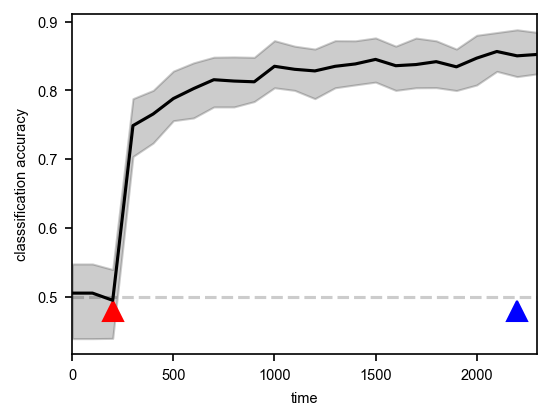

In [26]:
# for plotting: time axis, stim and resp times
t_plot = np.arange(activity.shape[1]) * config['dt']
stim_onset = t_plot[np.where(obs[0,:,1]!=0)[0][0]]
resp_onset= t_plot[np.where(obs[0,:,0]!=1)[0][0]]

# plot linear classification accuracy
plt.figure(figsize=(4,3), dpi=150)
plt.plot(t_plot, np.zeros(mean_acc.shape[1])+.5, 'k--', alpha=.2)
plt.plot(stim_onset, .48, '^', color = 'r', ms=10)
plt.plot(resp_onset, .48, '^', color='b', ms=10)
plt.plot(t_plot, np.mean(mean_acc, axis=0), 'k')
plt.fill_between(t_plot, ci_acc[0], ci_acc[1], color='k', alpha=.2)
plt.ylabel('classification accuracy')
plt.xlabel('time')
plt.xlim(t_plot[0],t_plot[-1])

We can see that before stimulus presentation, classification accuracy is at chance. In contrast, information about the stimulus rises quickly after. 

Will these network dynamics look different for stimuli of different coherence levels? Repeat the same analysis for each level of coherence (`info.coh.values`) and plot the mean accuracy with the pre-specified color gradient. To keep the plot clean, skip confidence intervals.

In [27]:
mean_acc = np.zeros([len(np.unique(info.coh.values)), n_splits, minmax_activity.shape[1]])

for ci,c in enumerate(np.unique(info.coh.values)):
    
    # condition index
    cidx = np.where(info.coh.values==c)
    
    for i in range(n_splits):    

        # transpose tensor to be shape [trials, time, neurons]
        for xi,x in enumerate(minmax_activity[cidx].transpose(1,0,2)):

            # train-test-split
            x_train, x_test, y_train, y_test = sklms.train_test_split(x, info.ground_truth.values[cidx], random_state=i)

            # fit to train data
            lda_fitted = sklda.LinearDiscriminantAnalysis(solver='lsqr').fit(X=x_train, y=y_train)

            # predict test set labels
            y_pred = lda_fitted.predict(x_test)

            # is the response correct for each trial?
            correct = 1 - np.abs(y_pred - y_test)

            mean_acc[ci,i,xi] = correct.mean()

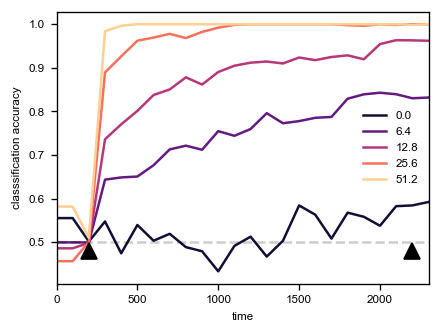

In [29]:
# colors corresponding to different values of color gradient
colors = plt.get_cmap('magma')(np.linspace(0.1,.9, len(np.unique(info.coh.values))))

# plot linear classification accuracy
plt.figure(figsize=(4,3), dpi=120)

# plot mean acc for each coherence level
for ci in range(len(np.unique(info.coh.values))):
    plt.plot(t_plot, np.mean(mean_acc[ci], axis=0), color=colors[ci], label=np.unique(info.coh.values)[ci])

plt.plot(t_plot, np.zeros(mean_acc[ci].shape[1])+.5, 'k--', alpha=.2)    
plt.plot(stim_onset, .48, '^', color = 'k', ms=10)
plt.plot(resp_onset, .48, '^', color='k', ms=10)
plt.ylabel('classification accuracy')
plt.xlabel('time')
plt.xlim(t_plot[0], t_plot[-1])
plt.legend(frameon=False)